# 551 Final Project Exploratory Data Analysis

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

%matplotlib inline


In [2]:
data = pd.read_json('data/traffic_data.json', orient='index', convert_axes=False)
data.head()

,Area ID,Premise Description,Location,month,day,year,hour,day_category
100100007,1,STREET,"(34.0395, -118.2656)",11,8,2010,22,night
100100767,1,STREET,"(34.0695, -118.2324)",3,31,2010,4,night
100100831,1,STREET,"(34.0424, -118.2718)",4,18,2010,1,night
100101004,1,STREET,"(34.0344, -118.2714)",6,5,2010,20,night
100101322,1,STREET,"(34.0637, -118.2361)",8,7,2010,16,evening


### Size of dataset

In [4]:
data.shape  # roughly 570000 observations and 8 variables (after removing ones that aren't interesting)

(570372, 8)

In [5]:
data.columns  # column names

Index(['Area ID', 'Premise Description', 'Location', 'month', 'day', 'year',
       'hour', 'day_category'],
      dtype='object')

In [7]:
data.info()  # datatypes and non-null counts

<class 'pandas.core.frame.DataFrame'>
Index: 570372 entries, 100100007 to 222104964
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Area ID              570372 non-null  int64 
 1   Premise Description  570372 non-null  object
 2   Location             570372 non-null  object
 3   month                570372 non-null  int64 
 4   day                  570372 non-null  int64 
 5   year                 570372 non-null  int64 
 6   hour                 570372 non-null  int64 
 7   day_category         570372 non-null  object
dtypes: int64(5), object(3)
memory usage: 39.2+ MB


In [8]:
data.nunique(axis=0)  # number of unique observations for each column

Area ID                   21
Premise Description      120
Location               50525
month                     12
day                       31
year                      13
hour                      23
day_category               4
dtype: int64

In [9]:
# Descriptive statistics for each numerical variable
data.describe()

,Area ID,month,day,year,hour
count,570372.000000,570372.000000,570372.000000,570372.000000,570372.000000
mean,11.081726,6.549103,15.642121,2015.387852,13.394834
std,5.875726,3.454172,8.783220,3.213909,5.845839
min,1.000000,1.000000,1.000000,2010.000000,1.000000
25%,6.000000,4.000000,8.000000,2013.000000,9.000000
50%,11.000000,7.000000,16.000000,2016.000000,14.000000
75%,16.000000,10.000000,23.000000,2018.000000,18.000000
max,21.000000,12.000000,31.000000,2022.000000,23.000000


In [10]:
# Categories for premise description
data['Premise Description'].unique()

array(['STREET', 'ALLEY', 'PARKING LOT', 'OTHER BUSINESS', 'SIDEWALK',
       'DRIVEWAY', 'OTHER PREMISE', 'LIBRARY', 'GARAGE/CARPORT',
       'SINGLE FAMILY DWELLING', 'FREEWAY', 'GAS STATION',
       'MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)',
       'PEDESTRIAN OVERCROSSING', 'STAIRWELL*', 'POLICE FACILITY',
       'OTHER/OUTSIDE', 'RESTAURANT/FAST FOOD', 'HIGH SCHOOL',
       'OTHER STORE', 'TRUCK, COMMERICAL', 'HOTEL', 'DRIVE THRU*',
       'PARKING UNDERGROUND/BUILDING', 'MINI-MART', 'VACANT LOT',
       'PARK/PLAYGROUND', 'VEHICLE, PASSENGER/TRUCK',
       'OFFICE BUILDING/OFFICE', 'BUS-CHARTER/PRIVATE',
       'JUNIOR HIGH SCHOOL', 'BUS STOP', 'ELEMENTARY SCHOOL',
       'TRANSPORTATION FACILITY (AIRPORT)', 'OTHER RESIDENCE',
       'ENTERTAINMENT/COMEDY CLUB (OTHER)',
       'BUS DEPOT/TERMINAL, OTHER THAN MTA',
       'GOVERNMENT FACILITY (FEDERAL,STATE, COUNTY & CITY)',
       'TRAIN TRACKS', '',
       'CHURCH/CHAPEL (CHANGED 03-03 FROM CHURCH/TEMPLE)',
       'BUS, SCH

In [11]:
# Categories for day_category
data.day_category.unique()

array(['night', 'evening', 'afternoon', 'morning'], dtype=object)

### Visualizations

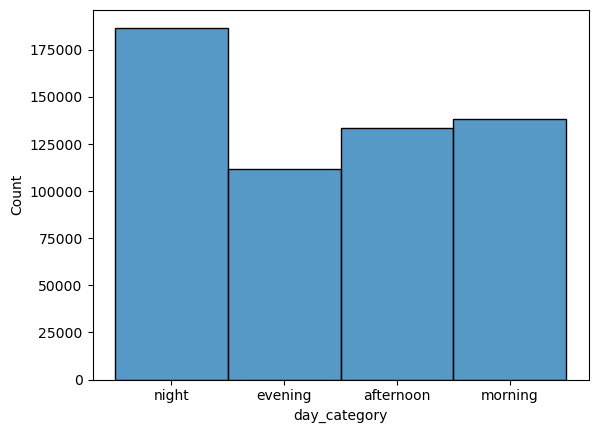

In [12]:
sns.histplot(data=data, x='day_category')
plt.show()

As one can see in the above visualization, more accidents seem to occur at night rather than at any other time. This was relatively suprising to me, as I would expect accidents to occur primarily in the morning/evening rush hours.

For our other categorical variable: `Premise Description` there are two many cateogries to display clearly in an image. Therefore, I will use the `value_counts` method to gain an understanding of the distribution.

In [13]:
tmp = pd.DataFrame(data['Premise Description'].value_counts()).rename(columns={'Premise Description': 'count'})
tmp['pct'] = tmp['count'] / 570372
tmp

,count,pct
STREET,543260,0.952466
PARKING LOT,18020,0.031593
SIDEWALK,3056,0.005358
ALLEY,1015,0.001780
DRIVEWAY,979,0.001716
...,...,...
REDLINE SUBWAY PLATFORM,1,0.000002
PRIVATE SCHOOL/PRESCHOOL,1,0.000002
"OTHER RR TRAIN (UNION PAC, SANTE FE ETC",1,0.000002
PAWN SHOP,1,0.000002


As expected, a large majority of the traffic accidents in Los angeles occur on the street (making up 95 percent of the total accidents present in this dataset). Each remaining category make up a very small proportion of the entire data.

##

### Overlaying accidents onto map of LA for initial visualization

In [14]:
# Need to convert location coordinates into separate latitude & longitude
data.Location.head(1)

100100007    (34.0395, -118.2656)
Name: Location, dtype: object

In [15]:
def get_latitude(loc):
    lat, _, _ = loc.partition(',')
    lat = lat.replace('(', '')

    return float(lat)

def get_longitude(loc):
    _, _, long = loc.partition(',')
    long = long.replace(')', '')

    return float(long)

In [16]:
get_latitude('(34.0395, -118.2656)')

34.0395

In [17]:
data['lat'] = data.Location.apply(get_latitude)
data['long'] = data.Location.apply(get_longitude)

In [19]:
data[['lat', 'long']]  # parse location coordinates into corresponding latitude and longitude

,lat,long
100100007,34.0395,-118.2656
100100767,34.0695,-118.2324
100100831,34.0424,-118.2718
100101004,34.0344,-118.2714
100101322,34.0637,-118.2361
...,...,...
222104843,34.1857,-118.5710
222104874,34.1938,-118.6059
222104886,34.1740,-118.5888
222104962,34.1624,-118.6285


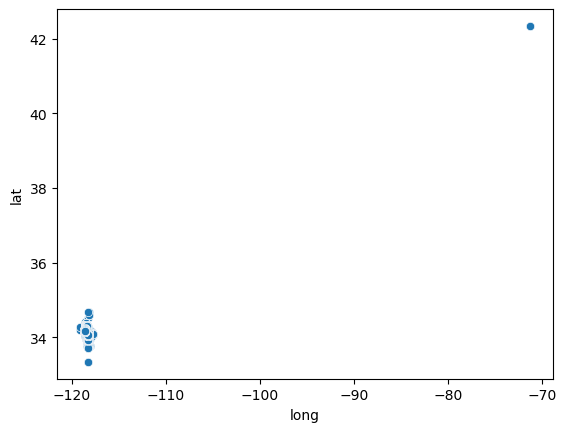

In [20]:
sns.scatterplot(data=data, x='long', y='lat')
plt.show()

In [21]:
data[data.lat > 40]

,Area ID,Premise Description,Location,month,day,year,hour,day_category,lat,long
211308053,13,STREET,"(42.3370413, -71.20922139999999)",4,3,2021,15,afternoon,42.337041,-71.209221
211319625,13,STREET,"(42.3370413, -71.20922139999999)",11,30,2021,13,afternoon,42.337041,-71.209221


Definitely a couple of outliers, looking at where the location is for both these areas, it comes to Newton, MA.

In [23]:
data = data[(data['lat'] <= 36) & (data['long'] <= -110)]  # filter our data to remove those two points

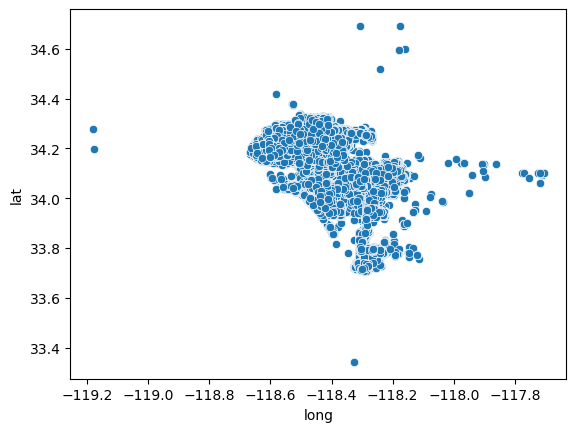

In [24]:
sns.scatterplot(data=data, x='long', y='lat')
plt.show()

We get a much clearer picture now that we've removed the points corresponding massachussets

In [28]:
bbox = ((data.long.min(), data.long.max(),
        data.lat.min(), data.lat.max()))

bbox

(-119.1805954, -117.7059, 33.3427, 34.692)

In [20]:
# Corresponds to accidents on catelina island --> ignore these as we are mainly concerned with mainland LA county
data[data.lat == min(data.lat)]

,Area ID,Premise Description,Location,month,day,year,hour,day_category,lat,long
112007970,20,STREET,"(33.3427, -118.3258)",3,8,2011,16,evening,33.3427,-118.3258
132012284,20,STREET,"(33.3427, -118.3258)",6,23,2013,1,night,33.3427,-118.3258


In [22]:
data = data[data.lat != min(data.lat)]

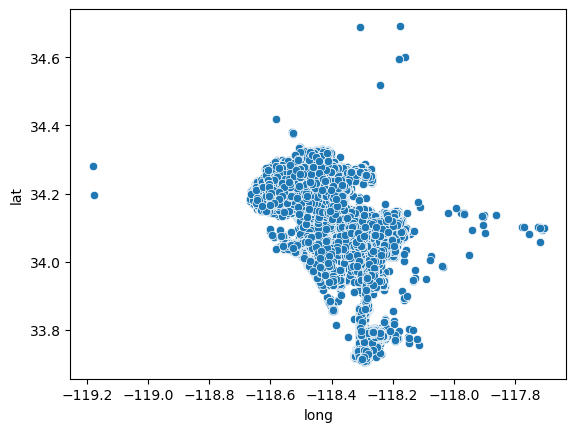

In [23]:
sns.scatterplot(data=data, x='long', y='lat')
plt.show()

In [24]:
# BBox = ((df.longitude.min(),   df.longitude.max(),      
#          df.latitude.min(), df.latitude.max())

bbox = ((data.long.min(), data.long.max(),
        data.lat.min(), data.lat.max()))

bbox

(-119.1805954, -117.7059, 33.7065, 34.692)

Based on this our bounding box region should be lat = (33.2, 34.8), long = (-119.2, -117.6)

link: https://www.openstreetmap.org/export#map=9/33.9731/-117.9402

In [74]:
Perhaps an 

SyntaxError: invalid syntax (<ipython-input-74-9ea82ec441d9>, line 1)

In [60]:
# # Find the categorical columns
# categorical_columns = (data_features.dtypes == object)

# # Setup two preprocessing pipelines
# from sklearn.pipeline        import Pipeline
# from sklearn.preprocessing   import StandardScaler, OneHotEncoder
# from sklearn.impute          import SimpleImputer

# con_pipe = Pipeline([('scaler', StandardScaler()),
#                       ('imputer', SimpleImputer(strategy='median', add_indicator=True))])

# cat_pipe = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore')),
#                      ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True))])

# from sklearn.compose         import ColumnTransformer

# preprocessing = ColumnTransformer([('categorical', cat_pipe,  categorical_columns),
#                                    ('continuous',  con_pipe, ~categorical_columns),
#                                    ])

# from sklearn.linear_model    import LogisticRegression

# pipe = Pipeline([('preprocessing', preprocessing), 
#                  ('clf', LogisticRegression(solver='liblinear'))])
# pipe.fit(X_train, y_train)
# pipe.predict(X_test, y_test)

In [32]:
X = data.drop(columns='Location')

str_cols = ['Premise Description', 'day_category']

cat_pipe = Pipeline([('ohe', OneHotEncoder())])
# con_pipe = Pipeline()

preprocessing = ColumnTransformer([('categorical', cat_pipe, str_cols)])
                                   # ('continuous', con_pipe, ~str_cols)])

# X = preprocessing.fit_transform(X)
# print(X)

pipe = Pipeline([('preprocessing', preprocessing),
                ('clstr', KMeans(n_clusters=3))])


pipe.fit(X)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['Premise Description',
                                                   'day_category'])])),
                ('clstr', KMeans(n_clusters=3))])

In [35]:
pipe['clstr'].labels_

array([1, 1, 1, ..., 0, 1, 0], dtype=int32)

In [36]:
new_data = data.copy()
new_data['labels'] = pipe['clstr'].labels_

In [37]:
new_data.head()

,Area ID,Premise Description,Location,month,day,year,hour,day_category,lat,long,labels
100100007,1,STREET,"(34.0395, -118.2656)",11,8,2010,22,night,34.0395,-118.2656,1
100100767,1,STREET,"(34.0695, -118.2324)",3,31,2010,4,night,34.0695,-118.2324,1
100100831,1,STREET,"(34.0424, -118.2718)",4,18,2010,1,night,34.0424,-118.2718,1
100101004,1,STREET,"(34.0344, -118.2714)",6,5,2010,20,night,34.0344,-118.2714,1
100101322,1,STREET,"(34.0637, -118.2361)",8,7,2010,16,evening,34.0637,-118.2361,0


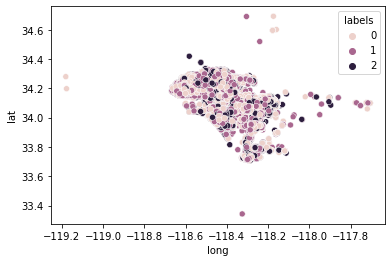

In [64]:
sns.scatterplot(data=new_data, x='long', y='lat', hue='labels')
plt.show()

In [45]:
pipe['clstr']

KMeans(n_clusters=3)

In [48]:
c0 = new_data[new_data.labels == 0]
c1 = new_data[new_data.labels == 1]
c2 = new_data[new_data.labels == 2]

#### Looking at cluster 0

In [51]:
c0.head()

,Area ID,Premise Description,Location,month,day,year,hour,day_category,lat,long,labels
100101322,1,STREET,"(34.0637, -118.2361)",8,7,2010,16,evening,34.0637,-118.2361,0
100104017,1,STREET,"(34.0453, -118.2651)",1,1,2010,12,afternoon,34.0453,-118.2651,0
100104019,1,STREET,"(34.0503, -118.2504)",1,1,2010,14,afternoon,34.0503,-118.2504,0
100104025,1,STREET,"(34.0369, -118.2522)",1,1,2010,17,evening,34.0369,-118.2522,0
100104026,1,STREET,"(34.0371, -118.2551)",1,1,2010,15,afternoon,34.0371,-118.2551,0


In [59]:
len(c2)

138416

<AxesSubplot:xlabel='long', ylabel='lat'>

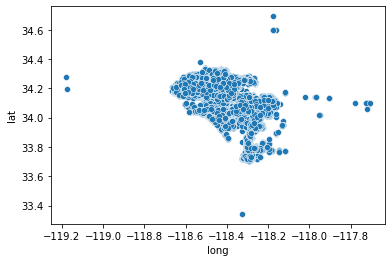

In [60]:
sns.scatterplot(data=c0, x='long', y='lat')

<AxesSubplot:xlabel='long', ylabel='lat'>

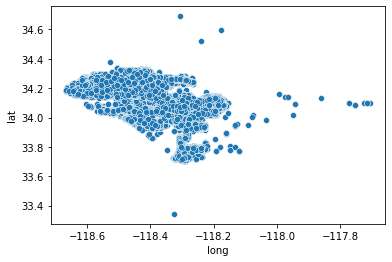

In [61]:
sns.scatterplot(data=c1, x='long', y='lat')

<AxesSubplot:xlabel='long', ylabel='lat'>

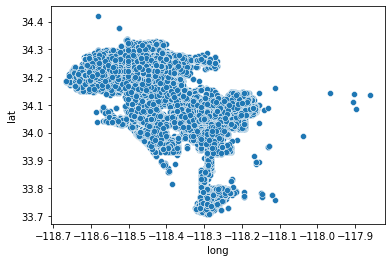

In [62]:
sns.scatterplot(data=c2, x='long', y='lat')

##### Looking at distribution of what days they occur

<AxesSubplot:xlabel='day_category', ylabel='Count'>

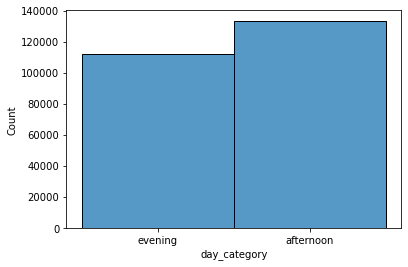

In [65]:
sns.histplot(data=c0, x='day_category')

<AxesSubplot:xlabel='day_category'>

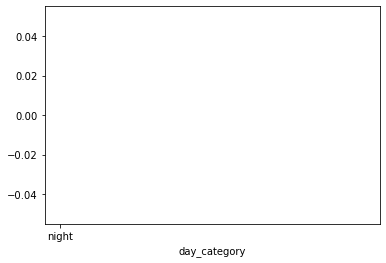

In [66]:
sns.scatterplot(data=c1, x='day_category')

In [69]:
c1.day_category.unique()

array(['night'], dtype=object)

All correspond to night

<AxesSubplot:xlabel='day_category'>

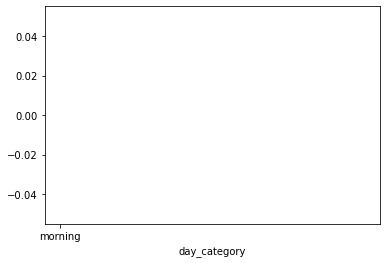

In [70]:
sns.scatterplot(data=c2, x='day_category')

In [71]:
c2.day_category.unique()

array(['morning'], dtype=object)